/newpage

# Config e imports

In [1]:
import calculos_montaña as cmr
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import Mnaf2025 as mnaf
import scipy.interpolate as scip
from scipy.interpolate import BSpline
from scipy.integrate import solve_ivp

has imported calculos_montaña package, contiene lo necesario para cálculos de montaña rusa
MNAF2025 imported successfully.


# **Simulación en 2D**

## ***Definición de las curvas a usar***

En el paquete definido como calculos_montaña tenemos en esencia lo necesario para hacer una montaña rusa, lo primero que tenemos que hacer antes de generar una función interpolante es definir las partes que queremos que tenga nuestra montaña rusa.
Los elementos que mínimo debe de tener esta montaña rusa son una gran bajada, una montañita y un looping, por lo tanto nuestra montaña rusa será de la siguiente manera
- gran bajada
- looping
- montañita (gaussiana)
- pequeña bajada
- looping
- recta final de frenado

En calculos de montaña tenemos lo necesario para calcular por partes estas secciones, luego las uniremos de forma que quede mas o menos uniforme y se parezca a una montaña rusa.

In [2]:
# Definimos la gran bajada de la montaña rusa
Gran_bajada = cmr.curva3d('s',np.linspace(-150,150,100),A=130,args=[0.05])

# Definimos el primer loop de la montaña rusa
Loop1 = cmr.curva3d('l',np.linspace(0,1.79,20),A=40,C=[Gran_bajada[0][-1],0,Gran_bajada[2][-1]],args=[0])

# Definimos montañita (gaussina)
Montañita = cmr.curva3d('g',np.linspace(-250,250,50),A=60,C=[Loop1[0][-1]+250,0,Loop1[2][-1]],args=[95])

# Definimos la pequeña bajada
Pequeña_bajada = cmr.curva3d('s',np.linspace(-100,100,20),A=20,C=[Montañita[0][-1]+100,0,Montañita[2][-1]-20],args=[0.1])

# Definimos el segundo loop de la montaña rusa
Loop2 = cmr.curva3d('l',np.linspace(0,1.79,10),A=30,C=[Pequeña_bajada[0][-1],0,Pequeña_bajada[2][-1]],args=[0])

# Recta final frenado
Recta_final = [Pequeña_bajada[0][-1]+np.linspace(0,200,20)+60,np.zeros(20),np.full(20,Loop2[2][-1])]

## ***Dibujo de la montaña rusa***

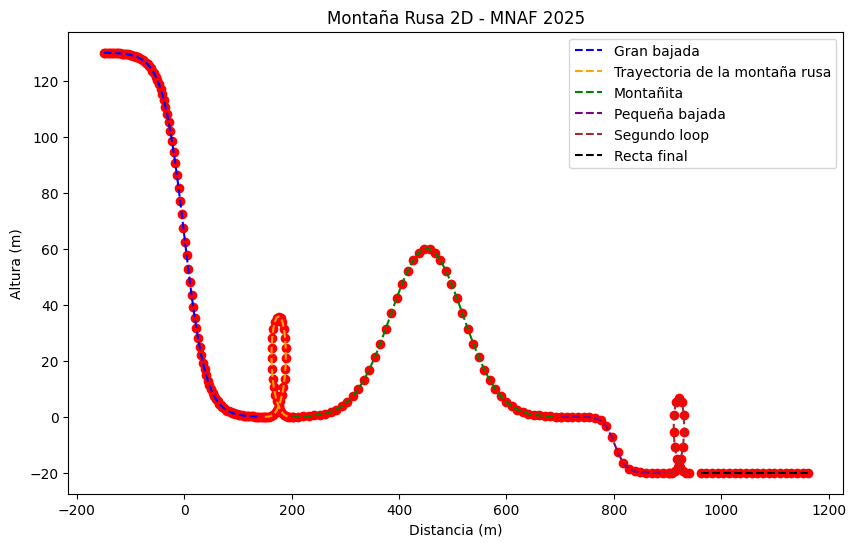

In [3]:
# ==============================================
# Gráfica de la montaña rusa
# ==============================================

plt.figure(figsize=(10,6))

# Graficar la gran bajada
plt.plot(Gran_bajada[0], Gran_bajada[2], 'o', color='red')
plt.plot(Gran_bajada[0], Gran_bajada[2], '--', color='blue', label='Gran bajada')

# Graficar el primer loop
plt.plot(Loop1[0], Loop1[2], 'o', color='red')
plt.plot(Loop1[0], Loop1[2], '--', color='orange', label='Trayectoria de la montaña rusa')

# Graficar la montañita
plt.plot(Montañita[0], Montañita[2], 'o', color='red')
plt.plot(Montañita[0], Montañita[2], '--', color='green', label='Montañita')

# Graficar la pequeña bajada
plt.plot(Pequeña_bajada[0], Pequeña_bajada[2], 'o', color='red')
plt.plot(Pequeña_bajada[0], Pequeña_bajada[2], '--', color='purple', label='Pequeña bajada')

# Graficar el segundo loop
plt.plot(Loop2[0], Loop2[2], 'o', color='red')
plt.plot(Loop2[0], Loop2[2], '--', color='brown', label='Segundo loop')

# Graficar la recta final
plt.plot(Recta_final[0], Recta_final[2], 'o', color='red')
plt.plot(Recta_final[0], Recta_final[2], '--', color='black', label='Recta final')

# Configuraciones de la gráfica
plt.legend()
plt.title('Montaña Rusa 2D - MNAF 2025')
plt.xlabel('Distancia (m)')
plt.ylabel('Altura (m)')
plt.show()



## ***Construimos la expresión paramétrica***


In [4]:
# Función que genera la expresión paramétrica
def montaña_rusa_parametrica(X_data=None, Z_data=None, Y_data=None, grado=3):
    '''
    Construye la expresión paramétrica r(t) mediante B-splines.
    
    Parámetros:
    -----------
    X_data : array-like
        Coordenadas horizontales (distancia)
    Z_data : array-like
        Coordenadas verticales (altura)
    grado : int
        Grado del B-spline (default=3, cúbico)
    
    Retorna:
    --------
    curva_bspline: expresión parámetrica evaluable con un parámetro [0,1]
    '''
    
    # Como hacemos una función 3D, si falta alguna coordenada la llenamos con ceros
    if X_data is None:
        X_data = np.full(len(Z_data), 0)
    elif Z_data is None:
        Z_data = np.full(len(X_data), 0)
    elif Y_data is None:
        Y_data = np.full(len(X_data), 0)
    
    # definimos los Puntos de control, serán los mismos datos
    puntos_control = np.array([X_data, Y_data, Z_data])  # Cada fila es una coordenada (X, Y, Z)

    # Definimos los nodos, debe cumplir la condición len(nodos) = len(puntos_control) + grado + 1
    nodos = np.array([0]*(grado) + list(np.linspace(0, 1, len(X_data)-grado)) + [1]*(grado)) #Ponemos los nodos al inicio y al final repetidos grado+1 veces para forzar a que la curva pase por los puntos extremos
    
    # Usamos la clase BSpline de scipy.interpolate
    curva_bspline = BSpline(nodos, puntos_control.T, grado)
    
    return curva_bspline
    

### ***Visualización de lo obtenido tras interpolar***

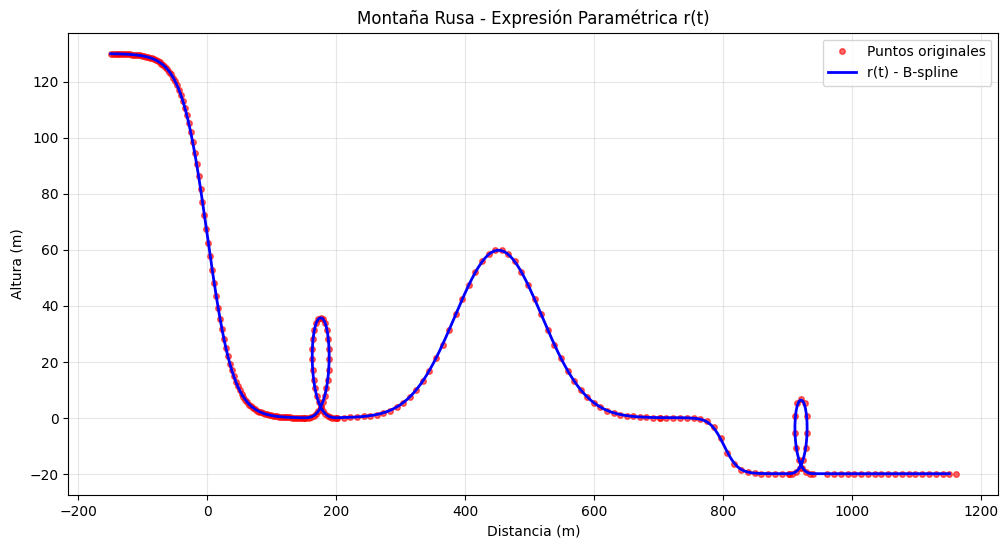

In [5]:
# Visualización usando la expresión paramétrica r(t)

#Construimos la expresión
Curva_parametrica = montaña_rusa_parametrica(
    X_data = np.concatenate([Gran_bajada[0], Loop1[0], Montañita[0], Pequeña_bajada[0], Loop2[0], Recta_final[0]]),
    Z_data = np.concatenate([Gran_bajada[2], Loop1[2], Montañita[2], Pequeña_bajada[2], Loop2[2], Recta_final[2]]),
)

# Evaluamos
t_eval = np.linspace(0, 1, 500)
Puntos_de_interpolación=Curva_parametrica(t_eval)

plt.figure(figsize=(12, 6))

# Gráfica comparativa
plt.plot(np.concatenate([Gran_bajada[0], Loop1[0], Montañita[0], Pequeña_bajada[0], Loop2[0], Recta_final[0]]),
         np.concatenate([Gran_bajada[2], Loop1[2], Montañita[2], Pequeña_bajada[2], Loop2[2], Recta_final[2]]),
         'o', color='red', markersize=4, label='Puntos originales', alpha=0.6)
plt.plot(Puntos_de_interpolación[:,0], Puntos_de_interpolación[:,2], '-', color='blue', linewidth=2, label='r(t) - B-spline')

plt.legend()
plt.title('Montaña Rusa - Expresión Paramétrica r(t)')
plt.xlabel('Distancia (m)')
plt.ylabel('Altura (m)')
plt.grid(True, alpha=0.3)
plt.show()


## ***Caso sin fricción***


Veamos como se comporta nuestra montaña rusa en caso de que no exista fricción

In [6]:
# ==============================================
# PREPARACIÓN DEL SISTEMA EDO
# ==============================================

# Concatenar datos completos de la montaña rusa
Distancia_data = np.concatenate([Gran_bajada[0], Loop1[0], Montañita[0], Pequeña_bajada[0], Loop2[0], Recta_final[0]])
Altura_data = np.concatenate([Gran_bajada[2], Loop1[2], Montañita[2], Pequeña_bajada[2], Loop2[2], Recta_final[2]])

# Calcular derivadas de la curva usando pkgmrusa UNA SOLA VEZ
derivadas_curva = cmr.trayec_der(Curva_parametrica)

# Parámetros físicos del sistema
masa = 500.0         # kg - masa del vagón
mu = 0.0             # coeficiente de rozamiento (0 = conservativo)
ca = 0.0             # coeficiente de arrastre aerodinámico (0 = conservativo)
Sf = 2.0             # m² - superficie frontal
rho_aire = 1.225     # kg/m³ - densidad del aire
g = 9.81             # m/s² - gravedad (VALOR POSITIVO, la función ya aplica el signo)
cvefVis = ca * Sf * rho_aire / (2 * masa)

# Condiciones iniciales [parámetro u0, velocidad v0]
u0 = 0.0              # inicio de la curva
v0 = 1.0              # m/s - velocidad inicial
y0 = [u0, v0]

#=============================================
# Sistema Sedo
#=============================================
def edo_montaña_rusa(t, y):
    '''
    Define el sistema de EDOs para la montaña rusa.
    
    Parámetros:
    -----------
    t : float
        Tiempo (no se usa explícitamente en este sistema)
    y : list
        Estado del sistema [posición u, velocidad v]
    
    Retorna:
    --------
    dydt : list
        Derivadas [du/dt, dv/dt]
    '''
    
    return cmr.edofun_mr(t, y, derivadas_curva, mu, cvefVis, g)

#Información del sistema
print("="*70)
print("SISTEMA EDO - CASO CONSERVATIVO")
print("="*70)
print(f"Parámetros físicos:")
print(f"  • Masa: {masa} kg")
print(f"  • Coef. rozamiento μ: {mu} (SIN FRICCIÓN)")
print(f"  • Coef. arrastre ca: {ca} (SIN ROZAMIENTO)")
print(f"  • Superficie frontal Sf: {Sf} m²")
print(f"  • Coeficiente viscoso cvefVis: {cvefVis} 1/m")
print(f"  • Gravedad: {g} m/s² (positivo)")
print(f"\nCondiciones iniciales:")
print(f"  • Posición inicial: u₀ = {u0}")
print(f"  • Velocidad inicial: v₀ = {v0} m/s")
print(f"\nDerivadas de la curva calculadas: {type(derivadas_curva)}")

SISTEMA EDO - CASO CONSERVATIVO
Parámetros físicos:
  • Masa: 500.0 kg
  • Coef. rozamiento μ: 0.0 (SIN FRICCIÓN)
  • Coef. arrastre ca: 0.0 (SIN ROZAMIENTO)
  • Superficie frontal Sf: 2.0 m²
  • Coeficiente viscoso cvefVis: 0.0 1/m
  • Gravedad: 9.81 m/s² (positivo)

Condiciones iniciales:
  • Posición inicial: u₀ = 0.0
  • Velocidad inicial: v₀ = 1.0 m/s

Derivadas de la curva calculadas: <class 'list'>


### ***Comparación de Métodos Numéricos***

#### ***Solución por los distintos metodos conocidos***

In [7]:
# Metodos a usar
Metodos=['RK45','RK23','DOP853','Radau','BDF','LSODA']
soluciones = {}
# Tiempo de evaluación
t_eval = np.linspace(0, 70, 1000)


# Resolución del Sedo por cada método
for metodo in Metodos:
    # Aquí iría la llamada a la función que resuelve la SEDO usando el método especificado
    x = solve_ivp(edo_montaña_rusa,[0,70],y0,method=metodo,t_eval=t_eval,dense_output=True)
    soluciones[metodo] = x

print (soluciones)

{'RK45':   message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  7.007e-02 ...  6.993e+01  7.000e+01]
        y: [[ 0.000e+00  3.175e-05 ...  1.016e+00  1.016e+00]
            [ 1.000e+00  1.003e+00 ...  5.531e+01  5.531e+01]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x733475cc1850>
 t_events: None
 y_events: None
     nfev: 242
     njev: 0
      nlu: 0, 'RK23':   message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  7.007e-02 ...  6.993e+01  7.000e+01]
        y: [[ 0.000e+00  3.175e-05 ...  1.015e+00  1.015e+00]
            [ 1.000e+00  1.003e+00 ...  5.420e+01  5.420e+01]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x733475cc2420>
 t_events: None
 y_events: None
     nfev: 344
     njev: 0
      nlu: 0, 'DOP853':   message: The solver successfully reached the end of the integration interval.

#### ***Visualicación de lo obtenido***

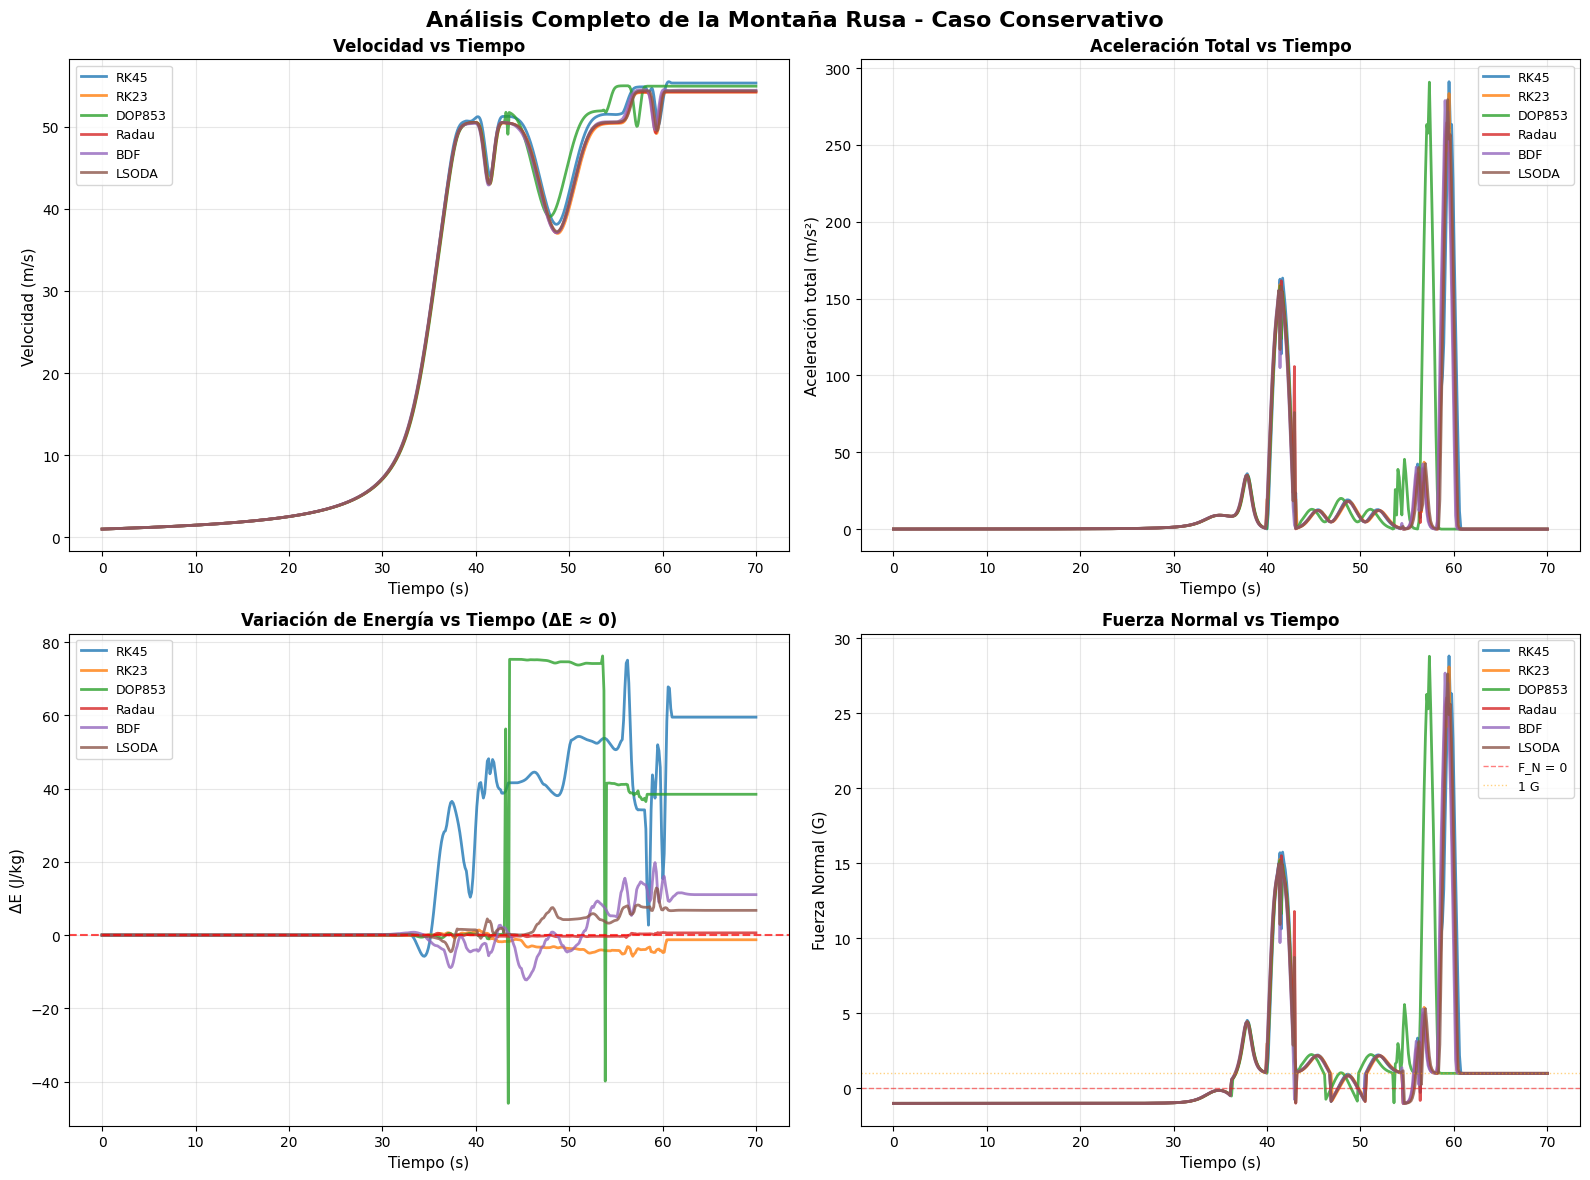


ANÁLISIS DE CONSERVACIÓN DE ENERGÍA: ¿Por qué Radau es la mejor opción?

RK45:
  • Desviación máxima de energía: 7.505167e+01 J/kg
  • Desviación media de energía:  2.281063e+01 J/kg

RK23:
  • Desviación máxima de energía: 5.791126e+00 J/kg
  • Desviación media de energía:  1.156529e+00 J/kg

DOP853:
  • Desviación máxima de energía: 7.620358e+01 J/kg
  • Desviación media de energía:  2.017535e+01 J/kg

Radau:
  • Desviación máxima de energía: 7.016928e-01 J/kg
  • Desviación media de energía:  1.846564e-01 J/kg

BDF:
  • Desviación máxima de energía: 1.978074e+01 J/kg
  • Desviación media de energía:  3.706252e+00 J/kg

LSODA:
  • Desviación máxima de energía: 1.285455e+01 J/kg
  • Desviación media de energía:  2.304471e+00 J/kg

--------------------------------------------------------------------------------
MÉTODO CON MENOR DESVIACIÓN: Radau
  → Desviación máxima: 7.016928e-01 J/kg
--------------------------------------------------------------------------------

📊 CONCLUSIÓN:
El m

In [8]:
# ==============================================
# GRÁFICAS COMBINADAS: Análisis completo del movimiento
# ==============================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis Completo de la Montaña Rusa - Caso Conservativo', fontsize=16, fontweight='bold')

# ==============================================
# 1. VELOCIDAD vs TIEMPO (subplot superior izquierdo)
# ==============================================
ax1 = axes[0, 0]
for metodo, sol in soluciones.items():
    ax1.plot(sol.t, sol.y[1], label=f'{metodo}', linewidth=2, alpha=0.8)
ax1.set_xlabel('Tiempo (s)', fontsize=11)
ax1.set_ylabel('Velocidad (m/s)', fontsize=11)
ax1.set_title('Velocidad vs Tiempo', fontsize=12, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)

# ==============================================
# 2. ACELERACIÓN TOTAL vs TIEMPO (subplot superior derecho)
# ==============================================
ax2 = axes[0, 1]
for metodo, sol in soluciones.items():
    # Calcular aceleración total para cada punto
    t_dense = np.linspace(sol.t[0], sol.t[-1], 500)
    datos = sol.sol(t_dense)
    u_vals = datos[0]
    v_vals = datos[1]
    
    aceleraciones = []
    for i in range(len(u_vals)):
        fuerzaN, baseLocal, ctes = cmr.fuerzaNormal(u_vals[i], v_vals[i], derivadas_curva, g)
        ace_total, ace_tg, ace_nr = cmr.aceleracion(v_vals[i], baseLocal, mu, cvefVis, fuerzaN, ctes[1], g)
        aceleraciones.append(ace_total)
    
    ax2.plot(t_dense, aceleraciones, label=f'{metodo}', linewidth=2, alpha=0.8)

ax2.set_xlabel('Tiempo (s)', fontsize=11)
ax2.set_ylabel('Aceleración total (m/s²)', fontsize=11)
ax2.set_title('Aceleración Total vs Tiempo', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)

# ==============================================
# 3. VARIACIÓN DE ENERGÍA vs TIEMPO (subplot inferior izquierdo)
# ==============================================
ax3 = axes[1, 0]
variaciones_energia = {}  # Guardar para análisis posterior

for metodo, sol in soluciones.items():
    # Calcular energía para cada punto
    t_dense = np.linspace(sol.t[0], sol.t[-1], 500)
    datos = sol.sol(t_dense)
    u_vals = datos[0]
    v_vals = datos[1]
    
    energias = []
    for i in range(len(u_vals)):
        E = cmr.energia(u_vals[i], v_vals[i], derivadas_curva[0], g)
        energias.append(E)
    
    # Energía inicial
    E0 = energias[0]
    # Variación de energía
    delta_E = np.array(energias) - E0
    variaciones_energia[metodo] = delta_E
    
    ax3.plot(t_dense, delta_E, label=f'{metodo}', linewidth=2, alpha=0.8)

ax3.set_xlabel('Tiempo (s)', fontsize=11)
ax3.set_ylabel('ΔE (J/kg)', fontsize=11)
ax3.set_title('Variación de Energía vs Tiempo (ΔE ≈ 0)', fontsize=12, fontweight='bold')
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='r', linestyle='--', linewidth=1.5, alpha=0.7)

# ==============================================
# 4. FUERZA NORMAL vs TIEMPO en unidades de G (subplot inferior derecho)
# ==============================================
ax4 = axes[1, 1]

# Graficar todos los métodos
for metodo, sol in soluciones.items():
    t_dense = np.linspace(sol.t[0], sol.t[-1], 500)
    datos = sol.sol(t_dense)
    u_vals = datos[0]
    v_vals = datos[1]
    
    fuerzas_normales_G = []
    
    for i in range(len(u_vals)):
        fuerzaN, baseLocal, ctes = cmr.fuerzaNormal(u_vals[i], v_vals[i], derivadas_curva, g)
        # Convertir a unidades de G (1 G = 9.81 m/s²)
        fuerzaN_G = fuerzaN / g
        fuerzas_normales_G.append(fuerzaN_G)
    
    ax4.plot(t_dense, fuerzas_normales_G, linewidth=2, alpha=0.8, label=metodo)

ax4.set_xlabel('Tiempo (s)', fontsize=11)
ax4.set_ylabel('Fuerza Normal (G)', fontsize=11)
ax4.set_title('Fuerza Normal vs Tiempo', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='r', linestyle='--', linewidth=1, alpha=0.5, label='F_N = 0')
ax4.axhline(y=1, color='orange', linestyle=':', linewidth=1, alpha=0.5, label='1 G')
ax4.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.show()

# ==============================================
# ANÁLISIS: ¿Por qué Radau es la mejor opción?
# ==============================================
print("\n" + "="*80)
print("ANÁLISIS DE CONSERVACIÓN DE ENERGÍA: ¿Por qué Radau es la mejor opción?")
print("="*80)

# Calcular la desviación máxima de energía para cada método
desviaciones = {}
for metodo, delta_E in variaciones_energia.items():
    desviacion_max = np.max(np.abs(delta_E))
    desviacion_media = np.mean(np.abs(delta_E))
    desviaciones[metodo] = (desviacion_max, desviacion_media)
    print(f"\n{metodo}:")
    print(f"  • Desviación máxima de energía: {desviacion_max:.6e} J/kg")
    print(f"  • Desviación media de energía:  {desviacion_media:.6e} J/kg")

# Identificar el mejor método
mejor_metodo = min(desviaciones.items(), key=lambda x: x[1][0])
print("\n" + "-"*80)
print(f"MÉTODO CON MENOR DESVIACIÓN: {mejor_metodo[0]}")
print(f"  → Desviación máxima: {mejor_metodo[1][0]:.6e} J/kg")
print("-"*80)

print("\n📊 CONCLUSIÓN:")
print(f"El método {mejor_metodo[0]} es la mejor opción para este sistema conservativo porque:")
print("  1. Minimiza la variación de energía (ΔE ≈ 0), respetando la conservación")
print("  2. Los métodos implícitos (Radau, BDF) son más estables para sistemas stiff")
print("  3. Radau es especialmente adecuado para problemas con restricciones físicas")
print("  4. Mantiene mejor la precisión en trayectorias con alta curvatura (loops)")
print("="*80 + "\n")

## ***Caso con fricción***

In [9]:
g = 9.8 #m/s^2 #aceleración de la gravedad
m = 800 #kg #masa del vagón con 4 pasajeros a bordo
mu = 0.015 #coeficiente de fricción
c_a = 0.4 #coeficiente de resistencia aerodinámica
S_f = 2 #m^2 #superficie frontal del vagón
ro_a = 1.225 #kg/m^3 #densidad del aire
c_v = (c_a*S_f*ro_a)/(2*m) #m^{-1} #coeficiente de la fuerza viscosa

# Condiciones iniciales [parámetro u0, velocidad v0]
u0 = 0.0              # inicio de la curva
v0 = 10.0              # m/s - velocidad inicial
y0 = [u0, v0]

#=============================================
# Sistema Sedo
#=============================================
def edo_montaña_rusa_no_conservativa(t, y):
    '''
    Define el sistema de EDOs para la montaña rusa.
    
    Parámetros:
    -----------
    t : float
        Tiempo (no se usa explícitamente en este sistema)
    y : list
        Estado del sistema [posición u, velocidad v]
    
    Retorna:
    --------
    dydt : list
        Derivadas [du/dt, dv/dt]
    '''
    
    return cmr.edofun_mr(t, y, derivadas_curva, mu, c_v, g)


#Información del sistema
print("="*70)
print("SISTEMA EDO - CASO NO CONSERVATIVO")
print("="*70)
print(f"Parámetros físicos:")
print(f"  • Masa: {masa} kg")
print(f"  • Coef. rozamiento μ: {mu} (SIN FRICCIÓN)")
print(f"  • Coef. arrastre ca: {ca} (SIN ROZAMIENTO)")
print(f"  • Superficie frontal Sf: {Sf} m²")
print(f"  • Coeficiente viscoso cvefVis: {c_v} 1/m")
print(f"  • Gravedad: {g} m/s² (positivo)")
print(f"\nCondiciones iniciales:")
print(f"  • Posición inicial: u₀ = {u0}")
print(f"  • Velocidad inicial: v₀ = {v0} m/s")
print(f"\nDerivadas de la curva calculadas: {type(derivadas_curva)}")

SISTEMA EDO - CASO NO CONSERVATIVO
Parámetros físicos:
  • Masa: 500.0 kg
  • Coef. rozamiento μ: 0.015 (SIN FRICCIÓN)
  • Coef. arrastre ca: 0.0 (SIN ROZAMIENTO)
  • Superficie frontal Sf: 2.0 m²
  • Coeficiente viscoso cvefVis: 0.0006125000000000001 1/m
  • Gravedad: 9.8 m/s² (positivo)

Condiciones iniciales:
  • Posición inicial: u₀ = 0.0
  • Velocidad inicial: v₀ = 10.0 m/s

Derivadas de la curva calculadas: <class 'list'>


In [10]:
t_eval = np.linspace(0, 100, 1000)

sol = solve_ivp(edo_montaña_rusa_no_conservativa,[0,100],y0,method="Radau",t_eval=t_eval,dense_output=True)


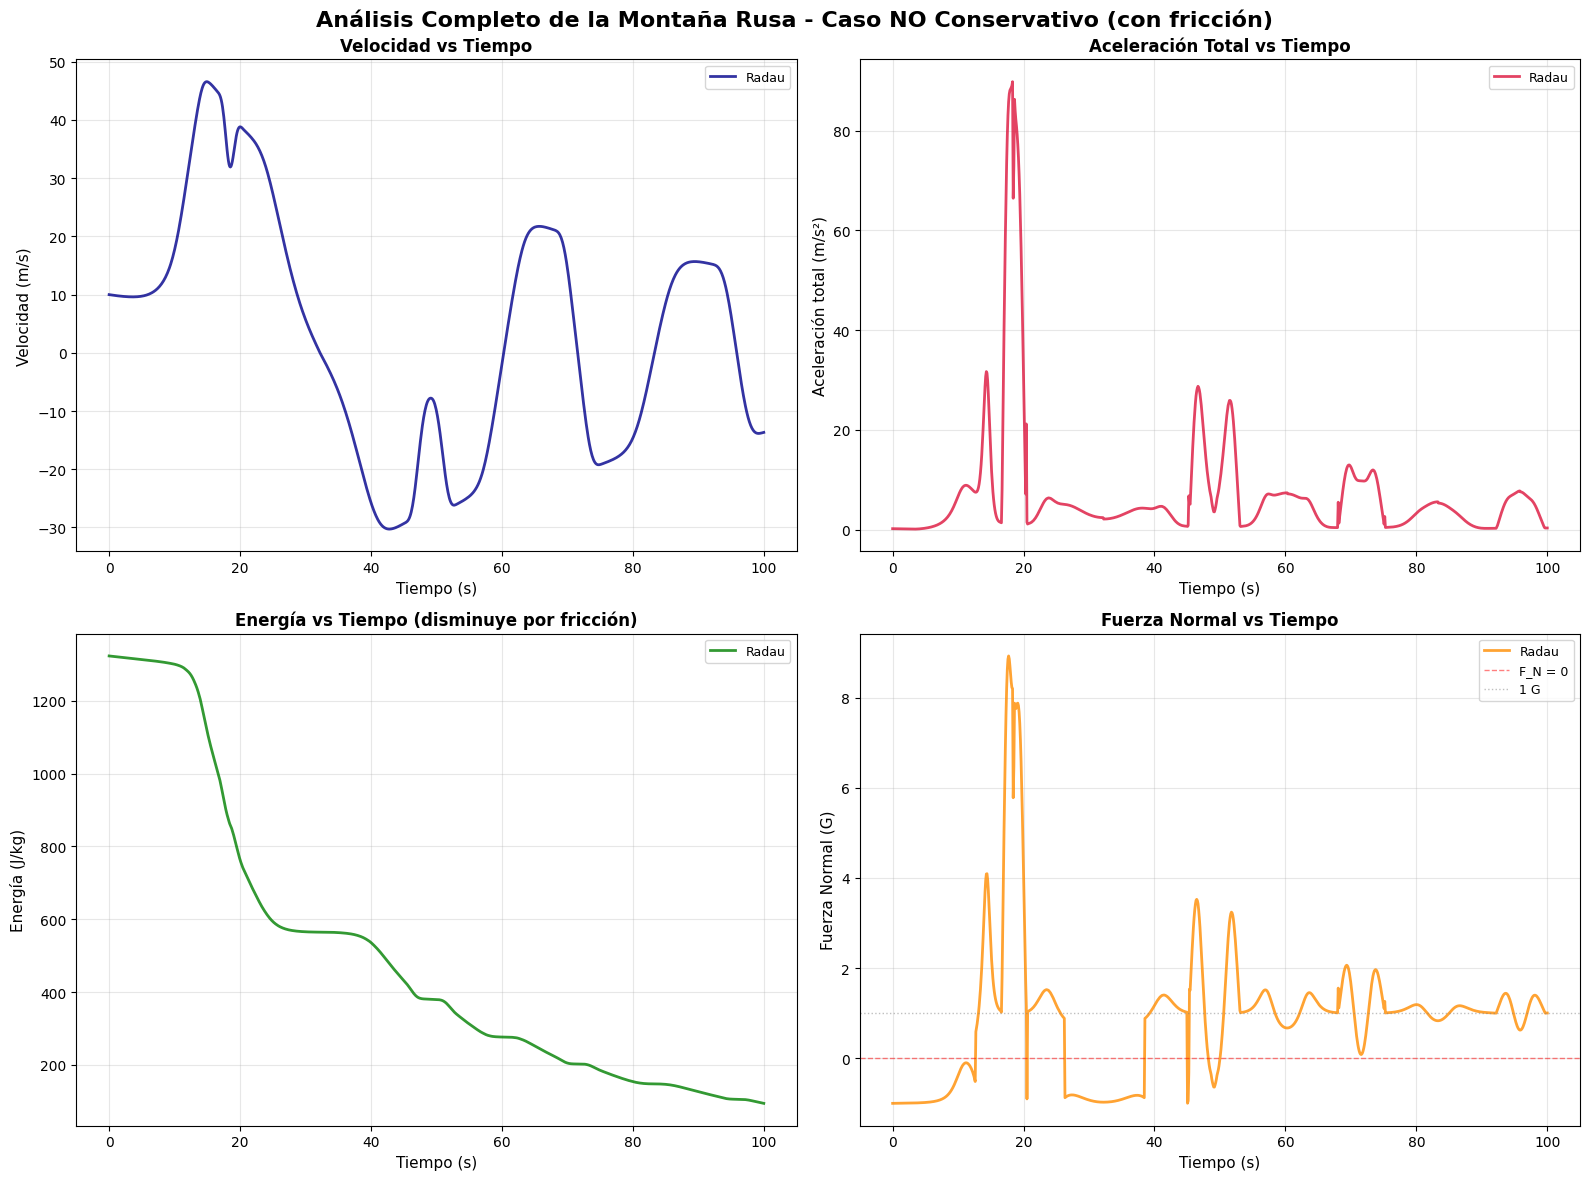


ANÁLISIS DE PÉRDIDA DE ENERGÍA - CASO CON FRICCIÓN

Energía inicial:  1323.30 J/kg
Energía final:    94.28 J/kg
Pérdida total:    1229.01 J/kg (92.88%)

Velocidad inicial: 10.00 m/s
Velocidad final:   -13.67 m/s

💡 La energía disminuye gradualmente debido a:
   • Fricción con la pista (μ = 0.015)
   • Resistencia aerodinámica (c_v = 0.000613 m⁻¹)



In [11]:
# ==============================================
# GRÁFICAS COMBINADAS: Análisis del movimiento con fricción
# ==============================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis Completo de la Montaña Rusa - Caso NO Conservativo (con fricción)', fontsize=16, fontweight='bold')

# Generar puntos densos para cálculos
t_dense = np.linspace(sol.t[0], sol.t[-1], 1000)
datos = sol.sol(t_dense)
u_vals = datos[0]
v_vals = datos[1]

# ==============================================
# 1. VELOCIDAD vs TIEMPO (subplot superior izquierdo)
# ==============================================
ax1 = axes[0, 0]
ax1.plot(t_dense, v_vals, linewidth=2, color='darkblue', alpha=0.8, label='Radau')
ax1.set_xlabel('Tiempo (s)', fontsize=11)
ax1.set_ylabel('Velocidad (m/s)', fontsize=11)
ax1.set_title('Velocidad vs Tiempo', fontsize=12, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)

# ==============================================
# 2. ACELERACIÓN TOTAL vs TIEMPO (subplot superior derecho)
# ==============================================
ax2 = axes[0, 1]

aceleraciones = []
for i in range(len(u_vals)):
    fuerzaN, baseLocal, ctes = cmr.fuerzaNormal(u_vals[i], v_vals[i], derivadas_curva, g)
    ace_total, ace_tg, ace_nr = cmr.aceleracion(v_vals[i], baseLocal, mu, c_v, fuerzaN, ctes[1], g)
    aceleraciones.append(ace_total)

ax2.plot(t_dense, aceleraciones, linewidth=2, color='crimson', alpha=0.8, label='Radau')
ax2.set_xlabel('Tiempo (s)', fontsize=11)
ax2.set_ylabel('Aceleración total (m/s²)', fontsize=11)
ax2.set_title('Aceleración Total vs Tiempo', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)

# ==============================================
# 3. ENERGÍA vs TIEMPO (subplot inferior izquierdo)
# ==============================================
ax3 = axes[1, 0]

energias = []
for i in range(len(u_vals)):
    E = cmr.energia(u_vals[i], v_vals[i], derivadas_curva[0], g)
    energias.append(E)

ax3.plot(t_dense, energias, linewidth=2, color='green', alpha=0.8, label='Radau')
ax3.set_xlabel('Tiempo (s)', fontsize=11)
ax3.set_ylabel('Energía (J/kg)', fontsize=11)
ax3.set_title('Energía vs Tiempo (disminuye por fricción)', fontsize=12, fontweight='bold')
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3)

# ==============================================
# 4. FUERZA NORMAL vs TIEMPO en unidades de G (subplot inferior derecho)
# ==============================================
ax4 = axes[1, 1]

fuerzas_normales_G = []

for i in range(len(u_vals)):
    fuerzaN, baseLocal, ctes = cmr.fuerzaNormal(u_vals[i], v_vals[i], derivadas_curva, g)
    # Convertir a unidades de G (1 G = 9.81 m/s²)
    fuerzaN_G = fuerzaN / g
    fuerzas_normales_G.append(fuerzaN_G)

ax4.plot(t_dense, fuerzas_normales_G, linewidth=2, color='darkorange', alpha=0.8, label='Radau')
ax4.set_xlabel('Tiempo (s)', fontsize=11)
ax4.set_ylabel('Fuerza Normal (G)', fontsize=11)
ax4.set_title('Fuerza Normal vs Tiempo', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='r', linestyle='--', linewidth=1, alpha=0.5, label='F_N = 0')
ax4.axhline(y=1, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='1 G')
ax4.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.show()

# ==============================================
# ANÁLISIS DE PÉRDIDA DE ENERGÍA
# ==============================================
print("\n" + "="*80)
print("ANÁLISIS DE PÉRDIDA DE ENERGÍA - CASO CON FRICCIÓN")
print("="*80)
E_inicial = energias[0]
E_final = energias[-1]
perdida_energia = E_inicial - E_final
porcentaje_perdida = (perdida_energia / E_inicial) * 100

print(f"\nEnergía inicial:  {E_inicial:.2f} J/kg")
print(f"Energía final:    {E_final:.2f} J/kg")
print(f"Pérdida total:    {perdida_energia:.2f} J/kg ({porcentaje_perdida:.2f}%)")
print(f"\nVelocidad inicial: {v_vals[0]:.2f} m/s")
print(f"Velocidad final:   {v_vals[-1]:.2f} m/s")
print(f"\n💡 La energía disminuye gradualmente debido a:")
print(f"   • Fricción con la pista (μ = {mu})")
print(f"   • Resistencia aerodinámica (c_v = {c_v:.6f} m⁻¹)")
print("="*80 + "\n")

## ***Animación: Sin Fricción vs Con Fricción***

In [12]:
# Importar módulo de animación
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Resolver ambos casos con el mismo tiempo de evaluación para comparación
t_max = 70  # tiempo máximo de simulación
t_eval_comp = np.linspace(0, t_max, 1000)

# Parámetros SIN fricción
mu_sin = 0.0
cv_sin = 0.0
v0_sin = 1.0
y0_sin = [0.0, v0_sin]



sol_sin_friccion = soluciones['Radau']

# Resolver CON fricción (ya tenemos estos parámetros definidos)
mu_con = 0.015
cv_con = c_v
v0_con = 10.0
y0_con = [0.0, v0_con]

sol_con_friccion = sol

print("="*70)
print("SOLUCIONES CALCULADAS PARA LA ANIMACIÓN")
print("="*70)
print(f"Caso SIN fricción:")
print(f"  • μ = {mu_sin}, c_v = {cv_sin}")
print(f"  • v₀ = {v0_sin} m/s")
print(f"  • Tiempo final alcanzado: {sol_sin_friccion.t[-1]:.2f} s")
print(f"\nCaso CON fricción:")
print(f"  • μ = {mu_con}, c_v = {cv_con:.6f} m⁻¹")
print(f"  • v₀ = {v0_con} m/s")
print(f"  • Tiempo final alcanzado: {sol_con_friccion.t[-1]:.2f} s")
print("="*70)

SOLUCIONES CALCULADAS PARA LA ANIMACIÓN
Caso SIN fricción:
  • μ = 0.0, c_v = 0.0
  • v₀ = 1.0 m/s
  • Tiempo final alcanzado: 70.00 s

Caso CON fricción:
  • μ = 0.015, c_v = 0.000613 m⁻¹
  • v₀ = 10.0 m/s
  • Tiempo final alcanzado: 100.00 s


In [ ]:
# ==============================================
# ANIMACIÓN COMPARATIVA: Sin Fricción vs Con Fricción
# ==============================================

# Configurar matplotlib para animaciones en notebook (VS Code usa widget)
%matplotlib widget

# Crear figura para la animación
fig, (ax_sin, ax_con) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Comparación: Movimiento con y sin Fricción', fontsize=14, fontweight='bold')

# ==============================================
# Subplot IZQUIERDO: SIN FRICCIÓN
# ==============================================
ax_sin.plot(Distancia_data, Altura_data, 'k-', linewidth=2, alpha=0.3, label='Pista')
vagon_sin, = ax_sin.plot([], [], 'ro', markersize=12, label='Vagón')
estela_sin, = ax_sin.plot([], [], 'r--', linewidth=1, alpha=0.4, label='Trayectoria')
ax_sin.set_xlabel('Distancia (m)', fontsize=10)
ax_sin.set_ylabel('Altura (m)', fontsize=10)
ax_sin.set_title('SIN Fricción (μ=0, c_v=0)', fontsize=11, fontweight='bold')
ax_sin.legend(loc='upper right', fontsize=8)
ax_sin.grid(True, alpha=0.3)
ax_sin.set_xlim(Distancia_data.min()-50, Distancia_data.max()+50)
ax_sin.set_ylim(Altura_data.min()-20, Altura_data.max()+20)

# Texto informativo para sin fricción
texto_sin = ax_sin.text(0.02, 0.98, '', transform=ax_sin.transAxes, 
                        fontsize=9, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# ==============================================
# Subplot DERECHO: CON FRICCIÓN
# ==============================================
ax_con.plot(Distancia_data, Altura_data, 'k-', linewidth=2, alpha=0.3, label='Pista')
vagon_con, = ax_con.plot([], [], 'bo', markersize=12, label='Vagón')
estela_con, = ax_con.plot([], [], 'b--', linewidth=1, alpha=0.4, label='Trayectoria')
ax_con.set_xlabel('Distancia (m)', fontsize=10)
ax_con.set_ylabel('Altura (m)', fontsize=10)
ax_con.set_title(f'CON Fricción (μ={mu_con}, c_v={cv_con:.4f})', fontsize=11, fontweight='bold')
ax_con.legend(loc='upper right', fontsize=8)
ax_con.grid(True, alpha=0.3)
ax_con.set_xlim(Distancia_data.min()-50, Distancia_data.max()+50)
ax_con.set_ylim(Altura_data.min()-20, Altura_data.max()+20)

# Texto informativo para con fricción
texto_con = ax_con.text(0.02, 0.98, '', transform=ax_con.transAxes,
                        fontsize=9, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# ==============================================
# Preparar datos para la animación
# ==============================================

# Obtener valores de u(t) y v(t) para ambos casos
t_max_sin = sol_sin_friccion.t[-1]
t_max_con = sol_con_friccion.t[-1]
t_max_anim = min(t_max_sin, t_max_con)  # Usar el mínimo para sincronizar

# Crear array de tiempos para la animación
n_frames = 500
t_anim = np.linspace(0, t_max_anim, n_frames)

# Obtener datos interpolados para cada frame
u_sin = sol_sin_friccion.sol(t_anim)[0]
v_sin = sol_sin_friccion.sol(t_anim)[1]

u_con = sol_con_friccion.sol(t_anim)[0]
v_con = sol_con_friccion.sol(t_anim)[1]

# Convertir u -> posiciones (x,y,z) usando la curva paramétrica
pos_sin = Curva_parametrica(u_sin)  # shape: (n_frames, 3)
pos_con = Curva_parametrica(u_con)

# Calcular energías para mostrar en la animación
energias_sin = [cmr.energia(u_sin[i], v_sin[i], derivadas_curva[0], g) for i in range(n_frames)]
energias_con = [cmr.energia(u_con[i], v_con[i], derivadas_curva[0], g) for i in range(n_frames)]

print(f"\nDatos preparados para animación:")
print(f"  • Número de frames: {n_frames}")
print(f"  • Duración: {t_max_anim:.2f} s")
print(f"  • Caso SIN fricción: energía inicial = {energias_sin[0]:.2f} J/kg")
print(f"  • Caso CON fricción: energía inicial = {energias_con[0]:.2f} J/kg")

# ==============================================
# Función de inicialización
# ==============================================
def init():
    vagon_sin.set_data([], [])
    estela_sin.set_data([], [])
    vagon_con.set_data([], [])
    estela_con.set_data([], [])
    texto_sin.set_text('')
    texto_con.set_text('')
    return vagon_sin, estela_sin, vagon_con, estela_con, texto_sin, texto_con

# ==============================================
# Función de actualización de frames
# ==============================================
def animate(frame):
    # Actualizar VAGÓN y ESTELA sin fricción
    x_sin = pos_sin[frame, 0]
    z_sin = pos_sin[frame, 2]
    vagon_sin.set_data([x_sin], [z_sin])
    
    # Estela (últimos 50 puntos)
    inicio_estela = max(0, frame-50)
    estela_sin.set_data(pos_sin[inicio_estela:frame+1, 0], pos_sin[inicio_estela:frame+1, 2])
    
    # Texto informativo sin fricción
    info_sin = (f"Tiempo: {t_anim[frame]:.2f} s\n"
                f"Velocidad: {v_sin[frame]:.2f} m/s\n"
                f"Energía: {energias_sin[frame]:.2f} J/kg\n"
                f"Posición u: {u_sin[frame]:.3f}")
    texto_sin.set_text(info_sin)
    
    # Actualizar VAGÓN y ESTELA con fricción
    x_con = pos_con[frame, 0]
    z_con = pos_con[frame, 2]
    vagon_con.set_data([x_con], [z_con])
    
    # Estela (últimos 50 puntos)
    estela_con.set_data(pos_con[inicio_estela:frame+1, 0], pos_con[inicio_estela:frame+1, 2])
    
    # Texto informativo con fricción
    info_con = (f"Tiempo: {t_anim[frame]:.2f} s\n"
                f"Velocidad: {v_con[frame]:.2f} m/s\n"
                f"Energía: {energias_con[frame]:.2f} J/kg\n"
                f"Posición u: {u_con[frame]:.3f}")
    texto_con.set_text(info_con)
    
    return vagon_sin, estela_sin, vagon_con, estela_con, texto_sin, texto_con

# ==============================================
# Crear animación
# ==============================================
anim = FuncAnimation(fig, animate, init_func=init, frames=n_frames, 
                     interval=20, blit=True, repeat=True)

plt.tight_layout()
plt.show()

print("\n✅ Animación lista! La animación se ejecuta automáticamente.")
print("   • ROJO: Sin fricción (conserva energía)")
print("   • AZUL: Con fricción (pierde energía)")
print("   • La animación se repite automáticamente")

In [14]:
# ==============================================
# Convertir animación a HTML5 video
# ==============================================

from IPython.display import HTML

# Convertir la animación a video HTML5 embebido
# Esto funciona en HTML exportado
print("Generando video HTML5 embebido...")
html_video = anim.to_html5_video()
html_anim = HTML(html_video)

# Mostrar en el notebook (también funcionará en HTML exportado)
display(html_anim)


Generando video HTML5 embebido...


## ***Caso realmente Viable***

In [91]:
# Definimos la gran bajada de la montaña rusa
Gran_bajada = cmr.curva3d('s',np.linspace(-250,250,100),A=70,args=[0.02])

# Definimos el primer loop de la montaña rusa
Loop1 = cmr.curva3d('l',np.linspace(0,1.79,20),A=33,C=[Gran_bajada[0][-1],0,Gran_bajada[2][-1]],args=[0])

# Definimos montañita (gaussina)
Montañita = cmr.curva3d('g',np.linspace(-250,250,50),A=10,C=[Loop1[0][-1]+250,0,Loop1[2][-1]],args=[95])

# Definimos la pequeña bajada
Pequeña_bajada = cmr.curva3d('s',np.linspace(-100,100,20),A=30,C=[Montañita[0][-1]+100,0,Montañita[2][-1]-30],args=[0.1])

# Definimos el segundo loop de la montaña rusa
Loop2 = cmr.curva3d('l',np.linspace(0,1.79,10),A=30,C=[Pequeña_bajada[0][-1],0,Pequeña_bajada[2][-1]],args=[0])

# Recta final frenado
Recta_final = [Pequeña_bajada[0][-1]+np.linspace(0,200,20)+60,np.zeros(20),np.full(20,Loop2[2][-1])]

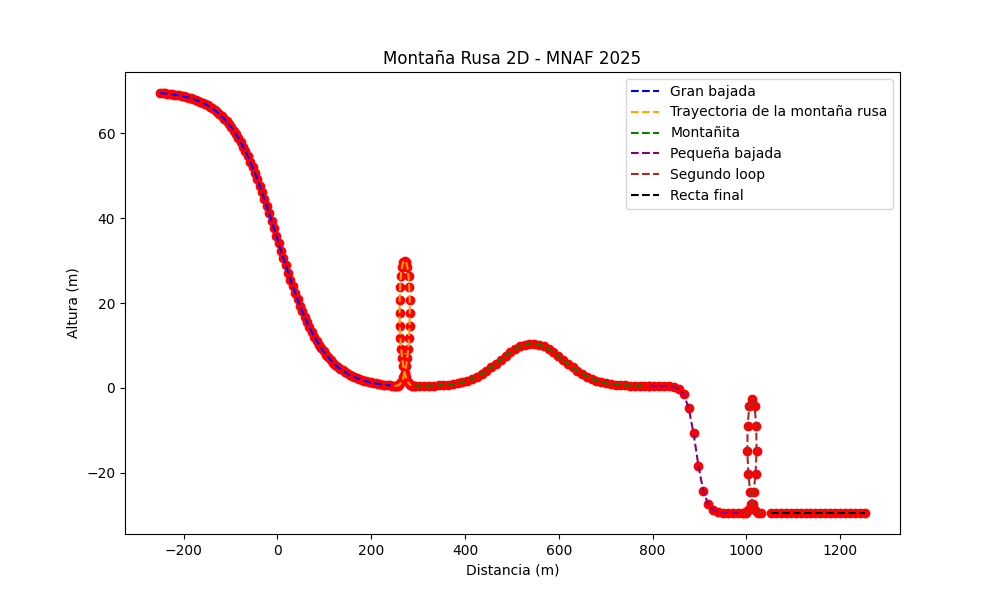

In [92]:
# ==============================================
# Gráfica de la montaña rusa
# ==============================================

plt.figure(figsize=(10,6))

# Graficar la gran bajada
plt.plot(Gran_bajada[0], Gran_bajada[2], 'o', color='red')
plt.plot(Gran_bajada[0], Gran_bajada[2], '--', color='blue', label='Gran bajada')

# Graficar el primer loop
plt.plot(Loop1[0], Loop1[2], 'o', color='red')
plt.plot(Loop1[0], Loop1[2], '--', color='orange', label='Trayectoria de la montaña rusa')

# Graficar la montañita
plt.plot(Montañita[0], Montañita[2], 'o', color='red')
plt.plot(Montañita[0], Montañita[2], '--', color='green', label='Montañita')

# Graficar la pequeña bajada
plt.plot(Pequeña_bajada[0], Pequeña_bajada[2], 'o', color='red')
plt.plot(Pequeña_bajada[0], Pequeña_bajada[2], '--', color='purple', label='Pequeña bajada')

# Graficar el segundo loop
plt.plot(Loop2[0], Loop2[2], 'o', color='red')
plt.plot(Loop2[0], Loop2[2], '--', color='brown', label='Segundo loop')

# Graficar la recta final
plt.plot(Recta_final[0], Recta_final[2], 'o', color='red')
plt.plot(Recta_final[0], Recta_final[2], '--', color='black', label='Recta final')

# Configuraciones de la gráfica
plt.legend()
plt.title('Montaña Rusa 2D - MNAF 2025')
plt.xlabel('Distancia (m)')
plt.ylabel('Altura (m)')
plt.show()



In [93]:
# Función que genera la expresión paramétrica
def montaña_rusa_parametrica(X_data=None, Z_data=None, Y_data=None, grado=3):
    '''
    Construye la expresión paramétrica r(t) mediante B-splines.
    
    Parámetros:
    -----------
    X_data : array-like
        Coordenadas horizontales (distancia)
    Z_data : array-like
        Coordenadas verticales (altura)
    grado : int
        Grado del B-spline (default=3, cúbico)
    
    Retorna:
    --------
    curva_bspline: expresión parámetrica evaluable con un parámetro [0,1]
    '''
    
    # Como hacemos una función 3D, si falta alguna coordenada la llenamos con ceros
    if X_data is None:
        X_data = np.full(len(Z_data), 0)
    elif Z_data is None:
        Z_data = np.full(len(X_data), 0)
    elif Y_data is None:
        Y_data = np.full(len(X_data), 0)
    
    # definimos los Puntos de control, serán los mismos datos
    puntos_control = np.array([X_data, Y_data, Z_data])  # Cada fila es una coordenada (X, Y, Z)

    # Definimos los nodos, debe cumplir la condición len(nodos) = len(puntos_control) + grado + 1
    nodos = np.array([0]*(grado) + list(np.linspace(0, 1, len(X_data)-grado)) + [1]*(grado)) #Ponemos los nodos al inicio y al final repetidos grado+1 veces para forzar a que la curva pase por los puntos extremos
    
    # Usamos la clase BSpline de scipy.interpolate
    curva_bspline = BSpline(nodos, puntos_control.T, grado)
    
    return curva_bspline
    

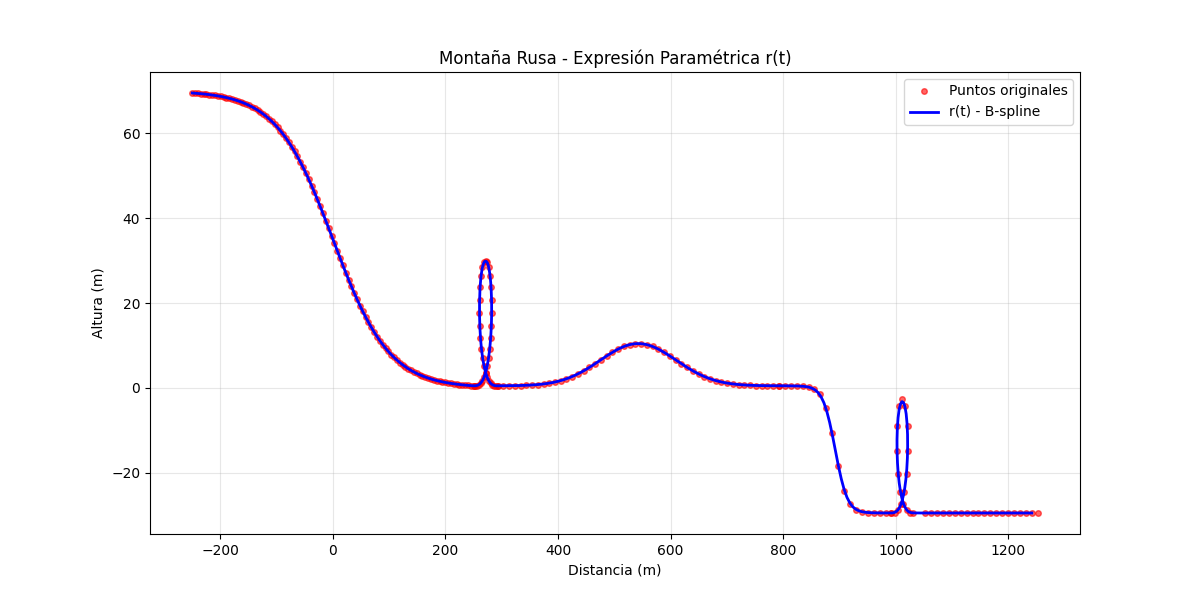

In [94]:
# Visualización usando la expresión paramétrica r(t)

#Construimos la expresión
Curva_parametrica = montaña_rusa_parametrica(
    X_data = np.concatenate([Gran_bajada[0], Loop1[0], Montañita[0], Pequeña_bajada[0], Loop2[0], Recta_final[0]]),
    Z_data = np.concatenate([Gran_bajada[2], Loop1[2], Montañita[2], Pequeña_bajada[2], Loop2[2], Recta_final[2]]),
)

# Evaluamos
t_eval = np.linspace(0, 1, 500)
Puntos_de_interpolación=Curva_parametrica(t_eval)

plt.figure(figsize=(12, 6))

# Gráfica comparativa
plt.plot(np.concatenate([Gran_bajada[0], Loop1[0], Montañita[0], Pequeña_bajada[0], Loop2[0], Recta_final[0]]),
         np.concatenate([Gran_bajada[2], Loop1[2], Montañita[2], Pequeña_bajada[2], Loop2[2], Recta_final[2]]),
         'o', color='red', markersize=4, label='Puntos originales', alpha=0.6)
plt.plot(Puntos_de_interpolación[:,0], Puntos_de_interpolación[:,2], '-', color='blue', linewidth=2, label='r(t) - B-spline')

plt.legend()
plt.title('Montaña Rusa - Expresión Paramétrica r(t)')
plt.xlabel('Distancia (m)')
plt.ylabel('Altura (m)')
plt.grid(True, alpha=0.3)
plt.show()


In [95]:
g = 9.8 #m/s^2 #aceleración de la gravedad
m = 800 #kg #masa del vagón con 4 pasajeros a bordo
mu = 0.015 #coeficiente de fricción
c_a = 0.4 #coeficiente de resistencia aerodinámica
S_f = 2 #m^2 #superficie frontal del vagón
ro_a = 1.225 #kg/m^3 #densidad del aire
c_v = (c_a*S_f*ro_a)/(2*m) #m^{-1} #coeficiente de la fuerza viscosa

# Condiciones iniciales [parámetro u0, velocidad v0]
u0 = 0.0              # inicio de la curva
v0 = 7.0              # m/s - velocidad inicial
y0 = [u0, v0]

#=============================================
# Sistema Sedo
#=============================================

# Calcular derivadas de la curva usando pkgmrusa UNA SOLA VEZ
derivadas_curva = cmr.trayec_der(Curva_parametrica)


def edo_montaña_rusa_no_conservativa(t, y):
    '''
    Define el sistema de EDOs para la montaña rusa.
    
    Parámetros:
    -----------
    t : float
        Tiempo (no se usa explícitamente en este sistema)
    y : list
        Estado del sistema [posición u, velocidad v]
    
    Retorna:
    --------
    dydt : list
        Derivadas [du/dt, dv/dt]
    '''
    
    return cmr.edofun_mr(t, y, derivadas_curva, mu, c_v, g)


#Información del sistema
print("="*70)
print("SISTEMA EDO - CASO NO CONSERVATIVO")
print("="*70)
print(f"Parámetros físicos:")
print(f"  • Masa: {masa} kg")
print(f"  • Coef. rozamiento μ: {mu} (SIN FRICCIÓN)")
print(f"  • Coef. arrastre ca: {ca} (SIN ROZAMIENTO)")
print(f"  • Superficie frontal Sf: {Sf} m²")
print(f"  • Coeficiente viscoso cvefVis: {c_v} 1/m")
print(f"  • Gravedad: {g} m/s² (positivo)")
print(f"\nCondiciones iniciales:")
print(f"  • Posición inicial: u₀ = {u0}")
print(f"  • Velocidad inicial: v₀ = {v0} m/s")
print(f"\nDerivadas de la curva calculadas: {type(derivadas_curva)}")

SISTEMA EDO - CASO NO CONSERVATIVO
Parámetros físicos:
  • Masa: 500.0 kg
  • Coef. rozamiento μ: 0.015 (SIN FRICCIÓN)
  • Coef. arrastre ca: 0.0 (SIN ROZAMIENTO)
  • Superficie frontal Sf: 2.0 m²
  • Coeficiente viscoso cvefVis: 0.0006125000000000001 1/m
  • Gravedad: 9.8 m/s² (positivo)

Condiciones iniciales:
  • Posición inicial: u₀ = 0.0
  • Velocidad inicial: v₀ = 7.0 m/s

Derivadas de la curva calculadas: <class 'list'>


In [96]:
t_eval = np.linspace(0, 100, 1000)

sol_viable = solve_ivp(edo_montaña_rusa_no_conservativa,[0,100],y0,method="Radau",t_eval=t_eval,dense_output=True)


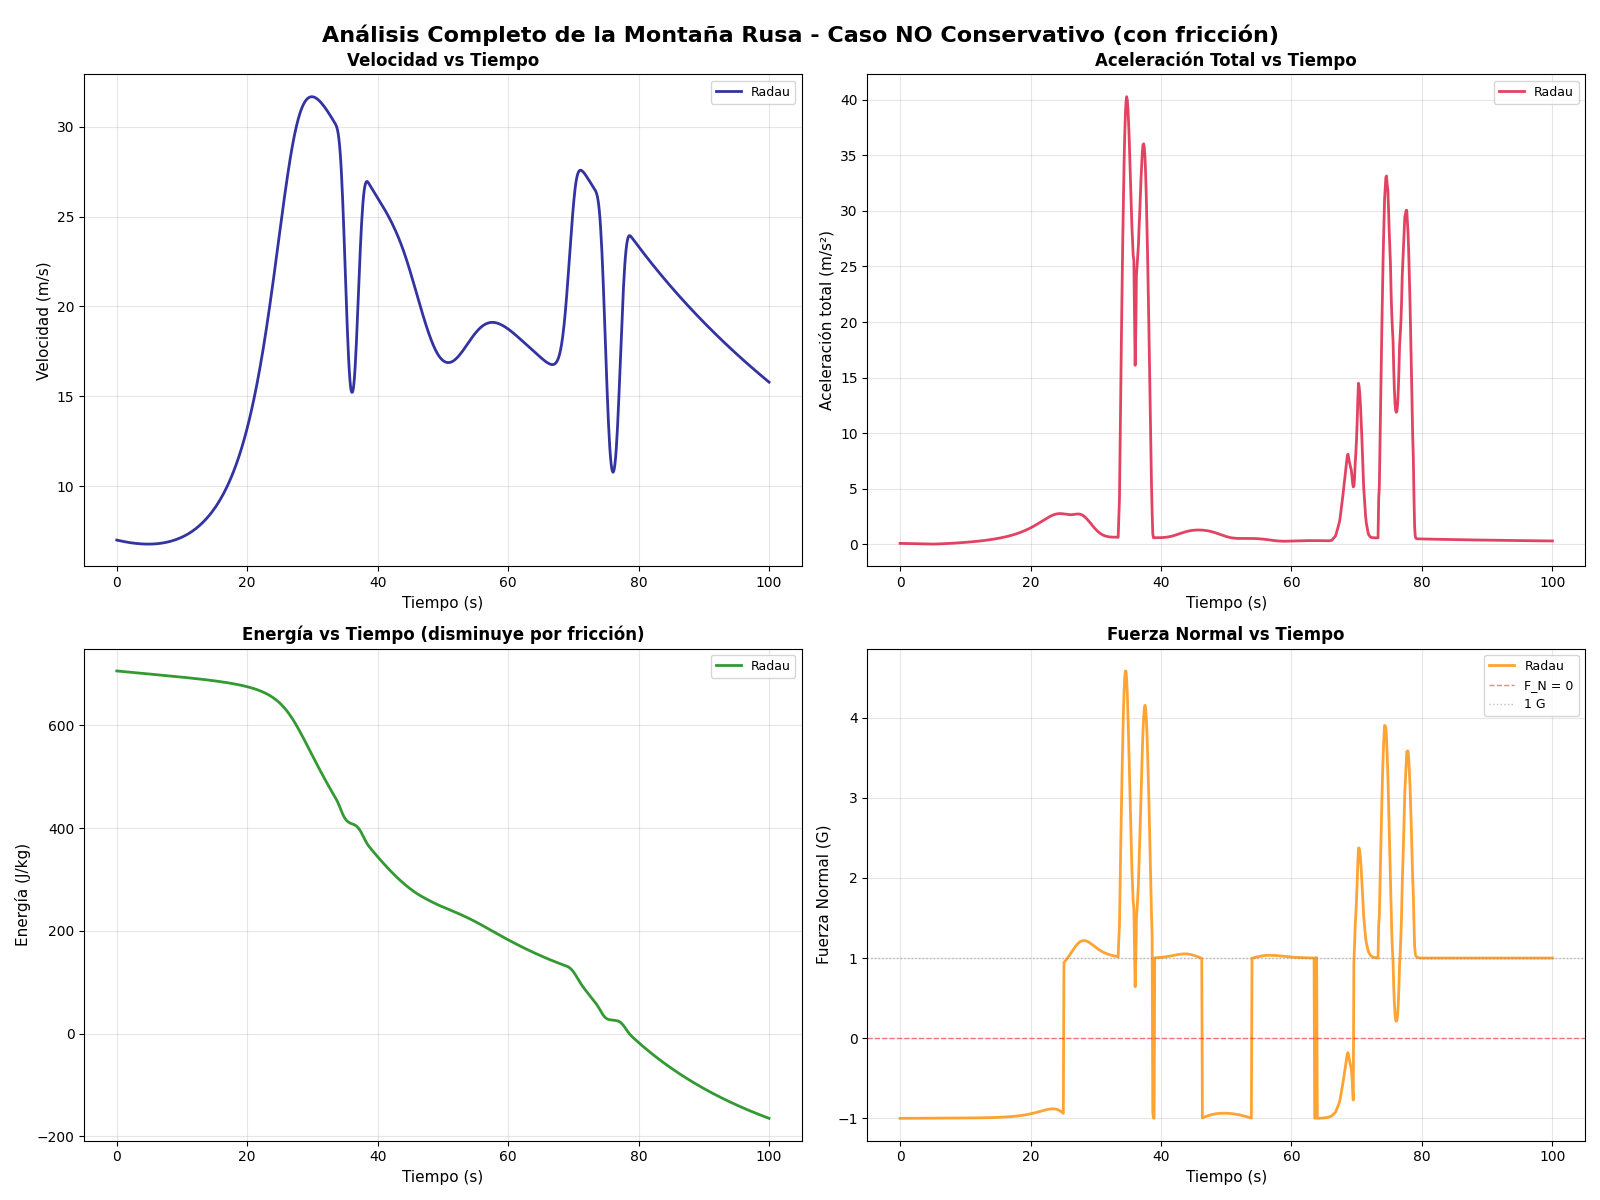


ANÁLISIS DE PÉRDIDA DE ENERGÍA - CASO CON FRICCIÓN

Energía inicial:  705.91 J/kg
Energía final:    -164.70 J/kg
Pérdida total:    870.61 J/kg (123.33%)

Velocidad inicial: 7.00 m/s
Velocidad final:   15.79 m/s

💡 La energía disminuye gradualmente debido a:
   • Fricción con la pista (μ = 0.015)
   • Resistencia aerodinámica (c_v = 0.000613 m⁻¹)



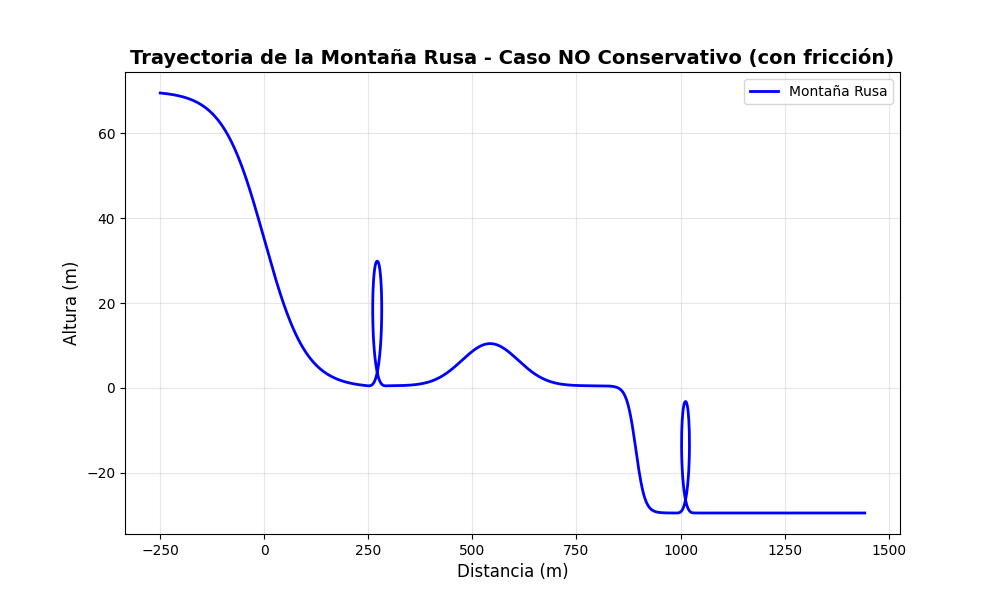

In [97]:
# ==============================================
# GRÁFICAS COMBINADAS: Análisis del movimiento con fricción
# ==============================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis Completo de la Montaña Rusa - Caso NO Conservativo (con fricción)', fontsize=16, fontweight='bold')

# Generar puntos densos para cálculos
t_dense = np.linspace(sol_viable.t[0], sol_viable.t[-1], 1000)
datos = sol_viable.sol(t_dense)
u_vals = datos[0]
v_vals = datos[1]

# ==============================================
# 1. VELOCIDAD vs TIEMPO (subplot superior izquierdo)
# ==============================================
ax1 = axes[0, 0]
ax1.plot(t_dense, v_vals, linewidth=2, color='darkblue', alpha=0.8, label='Radau')
ax1.set_xlabel('Tiempo (s)', fontsize=11)
ax1.set_ylabel('Velocidad (m/s)', fontsize=11)
ax1.set_title('Velocidad vs Tiempo', fontsize=12, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)

# ==============================================
# 2. ACELERACIÓN TOTAL vs TIEMPO (subplot superior derecho)
# ==============================================
ax2 = axes[0, 1]

aceleraciones = []
for i in range(len(u_vals)):
    fuerzaN, baseLocal, ctes = cmr.fuerzaNormal(u_vals[i], v_vals[i], derivadas_curva, g)
    ace_total, ace_tg, ace_nr = cmr.aceleracion(v_vals[i], baseLocal, mu, c_v, fuerzaN, ctes[1], g)
    aceleraciones.append(ace_total)

ax2.plot(t_dense, aceleraciones, linewidth=2, color='crimson', alpha=0.8, label='Radau')
ax2.set_xlabel('Tiempo (s)', fontsize=11)
ax2.set_ylabel('Aceleración total (m/s²)', fontsize=11)
ax2.set_title('Aceleración Total vs Tiempo', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)

# ==============================================
# 3. ENERGÍA vs TIEMPO (subplot inferior izquierdo)
# ==============================================
ax3 = axes[1, 0]

energias = []
for i in range(len(u_vals)):
    E = cmr.energia(u_vals[i], v_vals[i], derivadas_curva[0], g)
    energias.append(E)

ax3.plot(t_dense, energias, linewidth=2, color='green', alpha=0.8, label='Radau')
ax3.set_xlabel('Tiempo (s)', fontsize=11)
ax3.set_ylabel('Energía (J/kg)', fontsize=11)
ax3.set_title('Energía vs Tiempo (disminuye por fricción)', fontsize=12, fontweight='bold')
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3)

# ==============================================
# 4. FUERZA NORMAL vs TIEMPO en unidades de G (subplot inferior derecho)
# ==============================================
ax4 = axes[1, 1]

fuerzas_normales_G = []

for i in range(len(u_vals)):
    fuerzaN, baseLocal, ctes = cmr.fuerzaNormal(u_vals[i], v_vals[i], derivadas_curva, g)
    # Convertir a unidades de G (1 G = 9.81 m/s²)
    fuerzaN_G = fuerzaN / g
    fuerzas_normales_G.append(fuerzaN_G)

ax4.plot(t_dense, fuerzas_normales_G, linewidth=2, color='darkorange', alpha=0.8, label='Radau')
ax4.set_xlabel('Tiempo (s)', fontsize=11)
ax4.set_ylabel('Fuerza Normal (G)', fontsize=11)
ax4.set_title('Fuerza Normal vs Tiempo', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='r', linestyle='--', linewidth=1, alpha=0.5, label='F_N = 0')
ax4.axhline(y=1, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='1 G')
ax4.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.show()

# ==============================================
# ANÁLISIS DE PÉRDIDA DE ENERGÍA
# ==============================================
print("\n" + "="*80)
print("ANÁLISIS DE PÉRDIDA DE ENERGÍA - CASO CON FRICCIÓN")
print("="*80)
E_inicial = energias[0]
E_final = energias[-1]
perdida_energia = E_inicial - E_final
porcentaje_perdida = (perdida_energia / E_inicial) * 100

print(f"\nEnergía inicial:  {E_inicial:.2f} J/kg")
print(f"Energía final:    {E_final:.2f} J/kg")
print(f"Pérdida total:    {perdida_energia:.2f} J/kg ({porcentaje_perdida:.2f}%)")
print(f"\nVelocidad inicial: {v_vals[0]:.2f} m/s")
print(f"Velocidad final:   {v_vals[-1]:.2f} m/s")
print(f"\n💡 La energía disminuye gradualmente debido a:")
print(f"   • Fricción con la pista (μ = {mu})")
print(f"   • Resistencia aerodinámica (c_v = {c_v:.6f} m⁻¹)")
print("="*80 + "\n")


plt.figure(figsize=(10,6))
plt.plot(Curva_parametrica(sol_viable.sol(t_dense)[0])[:,0], Curva_parametrica(sol_viable.sol(t_dense)[0])[:,2], 'b-', linewidth=2, label='Montaña Rusa')
plt.title('Trayectoria de la Montaña Rusa - Caso NO Conservativo (con fricción)', fontsize=14, fontweight='bold')
plt.xlabel('Distancia (m)', fontsize=12)
plt.ylabel('Altura (m)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [ ]:
# ==============================================
# ANIMACIÓN DEL CASO VIABLE
# ==============================================

# Configurar matplotlib para animaciones en notebook
%matplotlib widget

# Crear figura para la animación
fig_viable, ax_viable = plt.subplots(figsize=(14, 7))
fig_viable.suptitle('Montaña Rusa - Caso Viable con Fricción', fontsize=14, fontweight='bold')

# Concatenar datos completos de la pista
Distancia_data_viable = np.concatenate([Gran_bajada[0], Loop1[0], Montañita[0], Pequeña_bajada[0], Loop2[0], Recta_final[0]])
Altura_data_viable = np.concatenate([Gran_bajada[2], Loop1[2], Montañita[2], Pequeña_bajada[2], Loop2[2], Recta_final[2]])

# Dibujar la pista
ax_viable.plot(Distancia_data_viable, Altura_data_viable, 'k-', linewidth=2, alpha=0.3, label='Pista')
vagon_viable, = ax_viable.plot([], [], 'go', markersize=14, label='Vagón', zorder=5)
estela_viable, = ax_viable.plot([], [], 'g--', linewidth=1.5, alpha=0.5, label='Trayectoria')

ax_viable.set_xlabel('Distancia (m)', fontsize=11)
ax_viable.set_ylabel('Altura (m)', fontsize=11)
ax_viable.set_title(f'μ = {mu}, c_v = {c_v:.6f} m⁻¹, v₀ = {v0} m/s', fontsize=11)
ax_viable.legend(loc='upper right', fontsize=10)
ax_viable.grid(True, alpha=0.3)
ax_viable.set_xlim(Distancia_data_viable.min()-50, Distancia_data_viable.max()+50)
ax_viable.set_ylim(Altura_data_viable.min()-20, Altura_data_viable.max()+20)

# Texto informativo
texto_viable = ax_viable.text(0.02, 0.98, '', transform=ax_viable.transAxes, 
                               fontsize=10, verticalalignment='top',
                               bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# ==============================================
# Preparar datos para la animación
# ==============================================

t_max_viable = sol_viable.t[-1]
n_frames_viable = 500
t_anim_viable = np.linspace(0, t_max_viable, n_frames_viable)

# Obtener datos interpolados
u_viable = sol_viable.sol(t_anim_viable)[0]
v_viable = sol_viable.sol(t_anim_viable)[1]

# Convertir u -> posiciones (x,y,z)
pos_viable = Curva_parametrica(u_viable)

# Calcular energías y fuerzas
energias_viable = []
fuerzas_G_viable = []

for i in range(n_frames_viable):
    E = cmr.energia(u_viable[i], v_viable[i], derivadas_curva[0], g)
    energias_viable.append(E)
    
    fuerzaN, baseLocal, ctes = cmr.fuerzaNormal(u_viable[i], v_viable[i], derivadas_curva, g)
    fuerzas_G_viable.append(fuerzaN / g)

print(f"\nDatos preparados para animación del caso viable:")
print(f"  • Número de frames: {n_frames_viable}")
print(f"  • Duración: {t_max_viable:.2f} s")
print(f"  • Energía inicial: {energias_viable[0]:.2f} J/kg")
print(f"  • Energía final: {energias_viable[-1]:.2f} J/kg")
print(f"  • Pérdida de energía: {energias_viable[0] - energias_viable[-1]:.2f} J/kg")

# ==============================================
# Funciones de animación
# ==============================================

def init_viable():
    vagon_viable.set_data([], [])
    estela_viable.set_data([], [])
    texto_viable.set_text('')
    return vagon_viable, estela_viable, texto_viable

def animate_viable(frame):
    # Actualizar vagón
    x_viable = pos_viable[frame, 0]
    z_viable = pos_viable[frame, 2]
    vagon_viable.set_data([x_viable], [z_viable])
    
    # Estela (últimos 80 puntos)
    inicio_estela = max(0, frame-80)
    estela_viable.set_data(pos_viable[inicio_estela:frame+1, 0], 
                           pos_viable[inicio_estela:frame+1, 2])
    
    # Texto informativo
    info = (f"⏱️ Tiempo: {t_anim_viable[frame]:.2f} s\n"
            f"🚄 Velocidad: {v_viable[frame]:.2f} m/s\n"
            f"⚡ Energía: {energias_viable[frame]:.2f} J/kg\n"
            f"⚖️ Fuerza Normal: {fuerzas_G_viable[frame]:.2f} G\n"
            f"📍 Posición: {u_viable[frame]:.3f}")
    texto_viable.set_text(info)
    
    return vagon_viable, estela_viable, texto_viable

# Crear animación
anim_viable = FuncAnimation(fig_viable, animate_viable, init_func=init_viable, 
                            frames=n_frames_viable, interval=20, blit=True, repeat=True)

plt.tight_layout()
plt.show()

print("\n✅ Animación del caso viable lista!")
print("   🟢 Montaña rusa con parámetros realistas")
print("   • Se repite automáticamente")

In [99]:
# ==============================================
# Convertir a HTML5 video (funciona en HTML exportado)
# ==============================================

from IPython.display import HTML

print("🎬 Generando video HTML5 embebido del caso viable...")
html_video_viable = anim_viable.to_html5_video()
html_anim_viable = HTML(html_video_viable)

# Mostrar en el notebook (también funcionará en HTML exportado)
display(html_anim_viable)

print("\n✅ Video HTML5 generado correctamente")
print("   📄 Esta versión SÍ funcionará cuando exportes el notebook a HTML")
print("   🌐 Se reproduce directamente en el navegador")

🎬 Generando video HTML5 embebido del caso viable...


/tmp/ipykernel_294777/2965788671.py:8: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  html_video_viable = anim_viable.to_html5_video()
/tmp/ipykernel_294777/2965788671.py:8: UserWarning: Glyph 128644 (\N{HIGH-SPEED TRAIN}) missing from font(s) DejaVu Sans.
  html_video_viable = anim_viable.to_html5_video()
/tmp/ipykernel_294777/2965788671.py:8: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  html_video_viable = anim_viable.to_html5_video()



✅ Video HTML5 generado correctamente
   📄 Esta versión SÍ funcionará cuando exportes el notebook a HTML
   🌐 Se reproduce directamente en el navegador
